#📌 Extracción

In [ ]:
#Importacion de librerias necesarias para el proyecto
import pandas as pd
import numpy as np
import requests
import json
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Librerías para visualización
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Configuración de estilo
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 12

In [53]:
#  Cargar JSON
df = pd.read_json('TelecomX_Data.json')
df.head()

,customerID,Churn,customer,phone,internet,account
0,0002-ORFBO,No,"{'gender': 'Female', 'SeniorCitizen': 0, 'Part...","{'PhoneService': 'Yes', 'MultipleLines': 'No'}","{'InternetService': 'DSL', 'OnlineSecurity': '...","{'Contract': 'One year', 'PaperlessBilling': '..."
1,0003-MKNFE,No,"{'gender': 'Male', 'SeniorCitizen': 0, 'Partne...","{'PhoneService': 'Yes', 'MultipleLines': 'Yes'}","{'InternetService': 'DSL', 'OnlineSecurity': '...","{'Contract': 'Month-to-month', 'PaperlessBilli..."
2,0004-TLHLJ,Yes,"{'gender': 'Male', 'SeniorCitizen': 0, 'Partne...","{'PhoneService': 'Yes', 'MultipleLines': 'No'}","{'InternetService': 'Fiber optic', 'OnlineSecu...","{'Contract': 'Month-to-month', 'PaperlessBilli..."
3,0011-IGKFF,Yes,"{'gender': 'Male', 'SeniorCitizen': 1, 'Partne...","{'PhoneService': 'Yes', 'MultipleLines': 'No'}","{'InternetService': 'Fiber optic', 'OnlineSecu...","{'Contract': 'Month-to-month', 'PaperlessBilli..."
4,0013-EXCHZ,Yes,"{'gender': 'Female', 'SeniorCitizen': 1, 'Part...","{'PhoneService': 'Yes', 'MultipleLines': 'No'}","{'InternetService': 'Fiber optic', 'OnlineSecu...","{'Contract': 'Month-to-month', 'PaperlessBilli..."


#🔧 Transformación

In [ ]:
# Expandir cada columna anidada
customer_expanded = pd.json_normalize(df['customer'])
phone_expanded = pd.json_normalize(df['phone'])
internet_expanded = pd.json_normalize(df['internet'])
account_expanded = pd.json_normalize(df['account'])

# Combinar todo 
df_final = pd.concat([
    df[['customerID', 'Churn']],
    customer_expanded,
    phone_expanded,
    internet_expanded,
    account_expanded
], axis=1)

df_final.head()

In [ ]:
# Verificar si 'charges' está anidado y expandirlo
if 'charges' in df_final.columns:
    charges_expanded = pd.json_normalize(df_final['charges'])
    df_final = pd.concat([df_final.drop('charges', axis=1), charges_expanded], axis=1)
  

In [52]:
# ===PRUEBAS===

df_final['Churn'].unique()

array([0, 1, ''], dtype=object)

In [ ]:
# Transformar sí/no 
for col in df_final.select_dtypes(include=['object']).columns:
    # Si veo que tiene 'Yes' o 'No' en los valores únicos
    valores = df_final[col].dropna().unique()
    tiene_yes_no = any(str(v) in ['Yes', 'No', 'yes', 'no'] for v in valores)
    
    if tiene_yes_no:
        df_final[col] = df_final[col].replace({'Yes': 1, 'No': 0, 'yes': 1, 'no': 0})
        print(f"{col} → transformada")

df_final.head()


#📊 Carga y análisis

In [ ]:
print("🔍 IDENTIFICANDO VALORES NULOS:")
print("=" * 50)

# Contar valores nulos por columna
valores_nulos = df_final.isnull().sum()
valores_nulos_total = valores_nulos.sum()

print(f"Total de valores nulos en el DataFrame: {valores_nulos_total}")
print("\nValores nulos por columna:")
print("-" * 30)

In [ ]:
#Crear cuentas diarias
df_final['Cuentas_Diarias'] = df_final['Charges.Monthly'] / 30

#Verificacion 
print("Cuentas_Diarias creada:")
print(df_final[['Charges.Monthly', 'Cuentas_Diarias']].head())



In [ ]:
variables_numericas = df_final.select_dtypes(include=[np.number]).columns
descripcion = df_final[variables_numericas].describe()

print(descripcion)

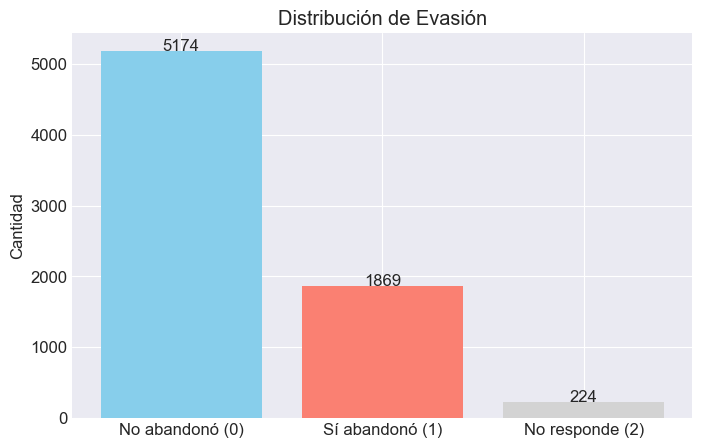

In [56]:
# En una línea: vacíos = 2
df_final['Churn'] = df_final['Churn'].replace('', 2).fillna(2).astype(int)

# Gráfico con leyenda
conteo = df_final['Churn'].value_counts()

plt.figure(figsize=(8, 5))
colores = ['skyblue', 'salmon', 'lightgray']
nombres = ['No abandonó (0)', 'Sí abandonó (1)', 'No responde (2)']

bars = plt.bar(nombres, [conteo.get(0,0), conteo.get(1,0), conteo.get(2,0)], color=colores)
plt.title('Distribución de Evasión')
plt.ylabel('Cantidad')

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 5, str(int(height)), ha='center')

plt.show()


gender:
--------------------
gender
Female    0.319
Male      0.318
Name: Churn, dtype: float64


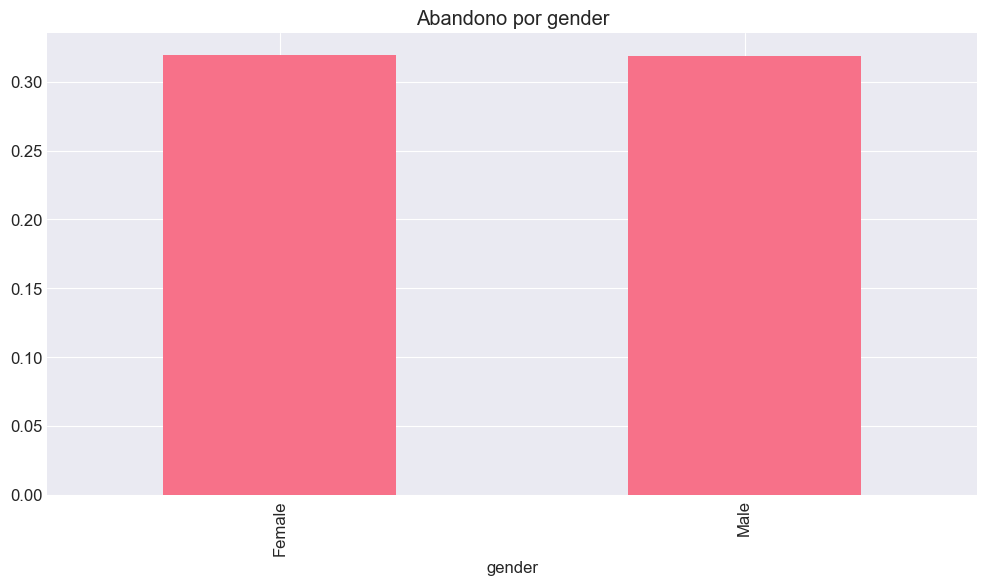


Contract:
--------------------
Contract
Month-to-month    0.478
One year          0.170
Two year          0.083
Name: Churn, dtype: float64


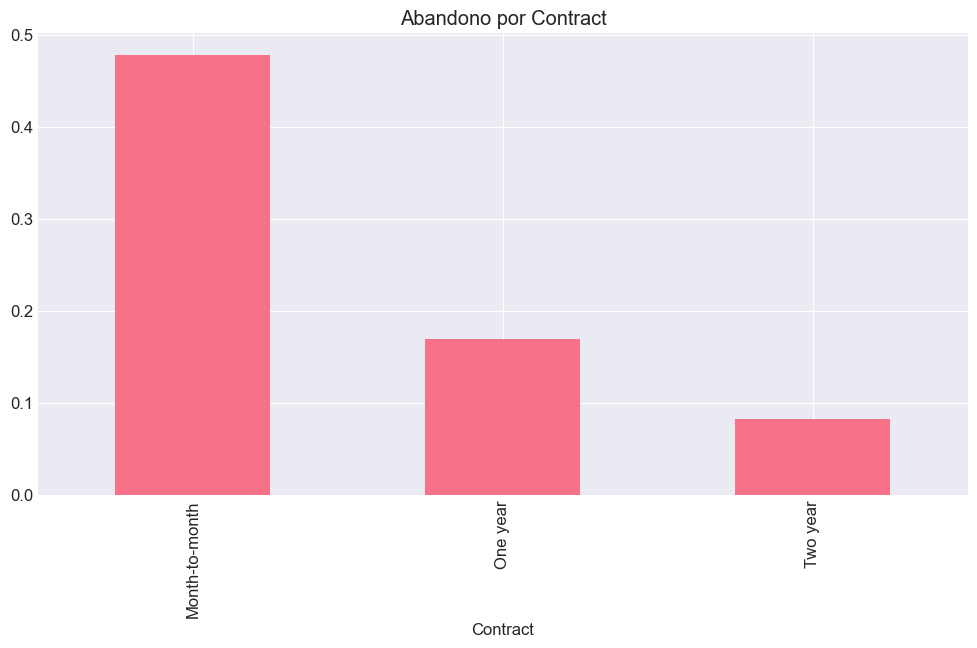


PaymentMethod:
--------------------
PaymentMethod
Bank transfer (automatic)    0.219
Credit card (automatic)      0.207
Electronic check             0.503
Mailed check                 0.249
Name: Churn, dtype: float64


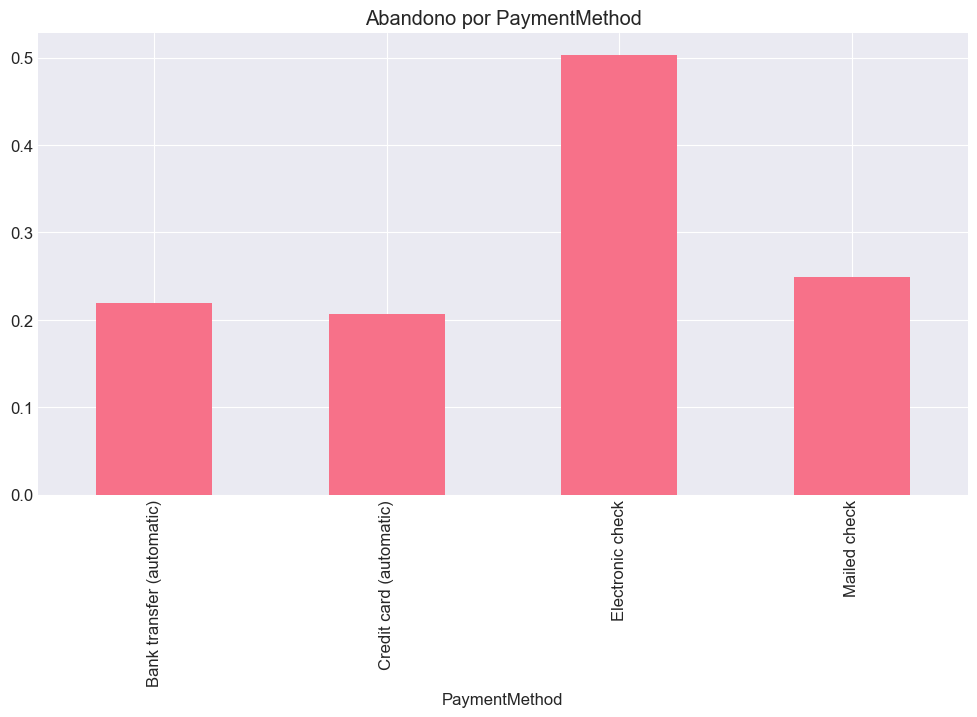


InternetService:
--------------------
InternetService
0              0.141
DSL            0.238
Fiber optic    0.469
Name: Churn, dtype: float64


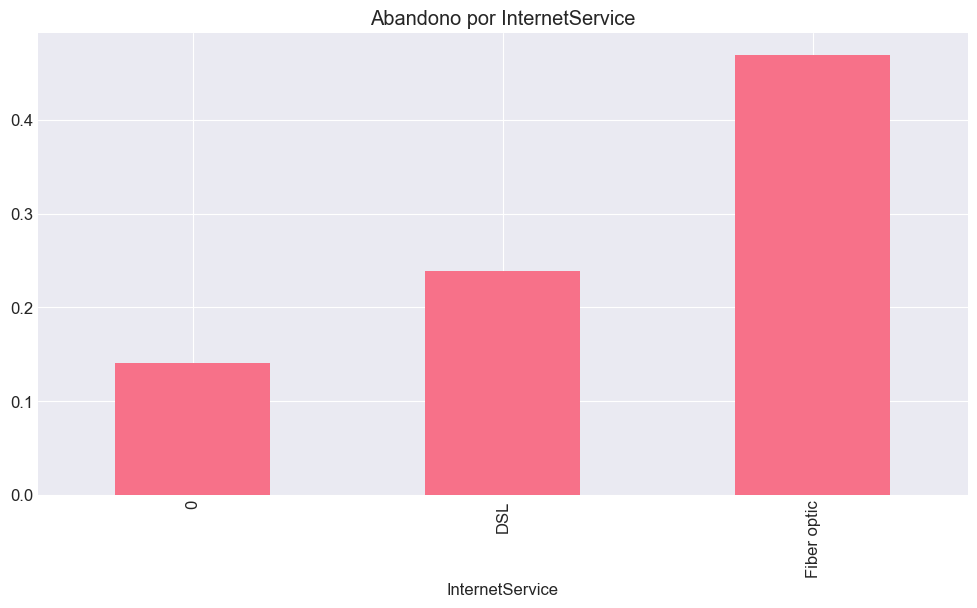

In [57]:


variables = ['gender', 'Contract', 'PaymentMethod', 'InternetService']

for var in variables:
    if var in df_final.columns:
        print(f"\n{var}:")
        print("-" * 20)
        
        # Tasa de abandono por categoría
        tasa = df_final.groupby(var)['Churn'].mean()
        print(tasa.round(3))
        
        # Gráfico simple
        tasa.plot(kind='bar')
        plt.title(f'Abandono por {var}')
        plt.show()

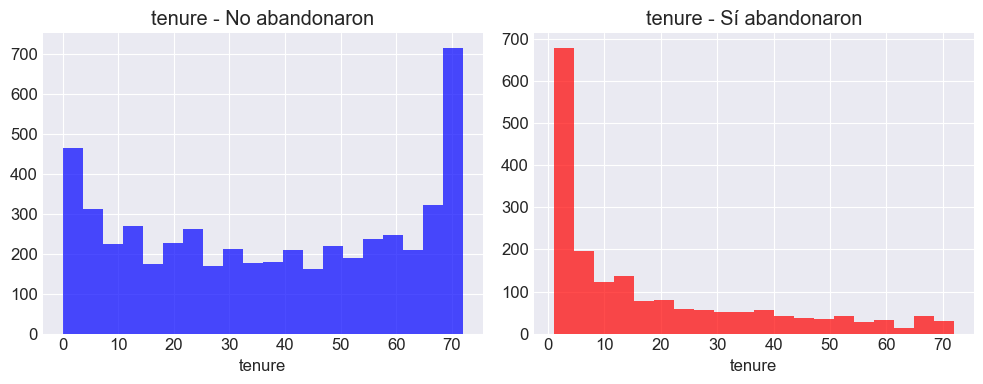

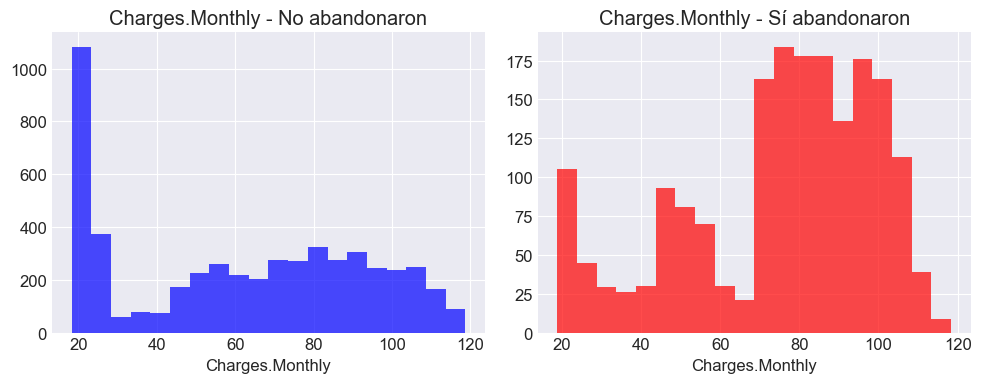

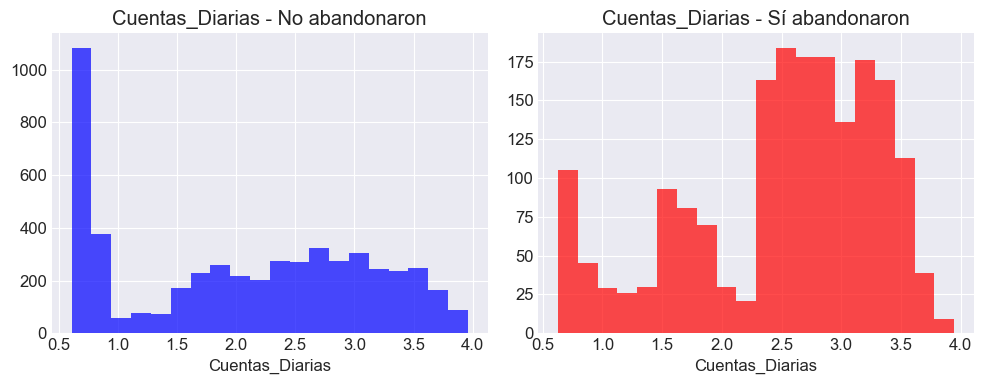

In [59]:

# VERSIÓN CON HISTOGRAMAS

variables = ['tenure', 'Charges.Monthly', 'Cuentas_Diarias']

for var in variables:
    if var in df_final.columns:
        plt.figure(figsize=(10, 4))
        
        # Histograma para No abandonaron
        plt.subplot(1, 2, 1)
        df_final[df_final['Churn'] == 0][var].hist(alpha=0.7, color='blue', bins=20)
        plt.title(f'{var} - No abandonaron')
        plt.xlabel(var)
        
        # Histograma para Sí abandonaron
        plt.subplot(1, 2, 2)
        df_final[df_final['Churn'] == 1][var].hist(alpha=0.7, color='red', bins=20)
        plt.title(f'{var} - Sí abandonaron')
        plt.xlabel(var)
        
        plt.tight_layout()
        plt.show()

#📄Informe final